<a href="https://colab.research.google.com/github/GaborVxxx/ml_notes/blob/main/L4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make a working classification model that use non liear layers to pick up non linear patterns

playground: https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=0&networkShape=5,5,2&seed=0.73834&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

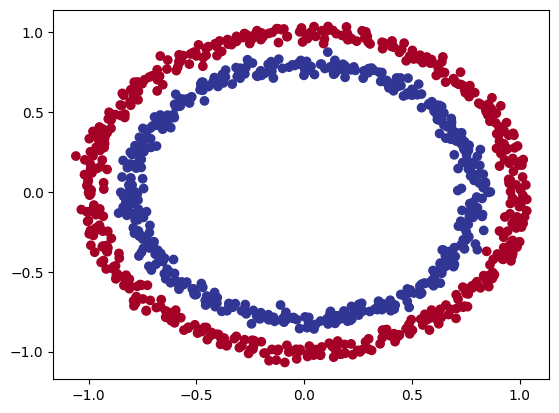

In [64]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import numpy as np

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [65]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [66]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2, 10)
    self.layer_2 = nn.Linear(10, 10)
    self.layer_3 = nn.Linear(10, 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model = CircleModel().to(device)
model


CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [67]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [68]:
# UTIL functions
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [69]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train.to(device).squeeze(dim=1))

  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train.to(device).unsqueeze(dim=1))
  acc = accuracy_fn(y_true=y_train.to(device).squeeze(),
                  y_pred=y_pred.to(device).squeeze())

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()

  with torch.inference_mode():
    y_logits_test = model(X_test.to(device).squeeze(dim=1))

    y_pred_test = torch.round(torch.sigmoid(y_logits_test))

    test_loss = loss_fn(y_logits_test, y_test.to(device).unsqueeze(dim=1))
    acc_test = accuracy_fn(y_true=y_test.to(device).squeeze(),
                    y_pred=y_pred_test.to(device).squeeze())

  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, loss: {loss:.2f}, testloss: {test_loss:.2f}, acc: {acc:.2f}%, test acc: {acc_test:.2f}%")


Epoch: 0, loss: 0.69, testloss: 0.69, acc: 50.00%, test acc: 50.00%
Epoch: 10, loss: 0.69, testloss: 0.69, acc: 50.50%, test acc: 50.00%
Epoch: 20, loss: 0.69, testloss: 0.69, acc: 59.13%, test acc: 56.50%
Epoch: 30, loss: 0.69, testloss: 0.69, acc: 70.25%, test acc: 68.00%
Epoch: 40, loss: 0.69, testloss: 0.69, acc: 68.38%, test acc: 71.00%
Epoch: 50, loss: 0.69, testloss: 0.69, acc: 58.25%, test acc: 58.00%
Epoch: 60, loss: 0.69, testloss: 0.69, acc: 54.00%, test acc: 54.50%
Epoch: 70, loss: 0.69, testloss: 0.69, acc: 53.12%, test acc: 53.00%
Epoch: 80, loss: 0.69, testloss: 0.69, acc: 52.62%, test acc: 53.00%
Epoch: 90, loss: 0.69, testloss: 0.69, acc: 52.75%, test acc: 53.00%
Epoch: 100, loss: 0.69, testloss: 0.69, acc: 52.88%, test acc: 52.50%
Epoch: 110, loss: 0.69, testloss: 0.69, acc: 52.88%, test acc: 53.50%
Epoch: 120, loss: 0.69, testloss: 0.69, acc: 53.12%, test acc: 54.00%
Epoch: 130, loss: 0.69, testloss: 0.69, acc: 53.00%, test acc: 54.50%
Epoch: 140, loss: 0.69, testlos

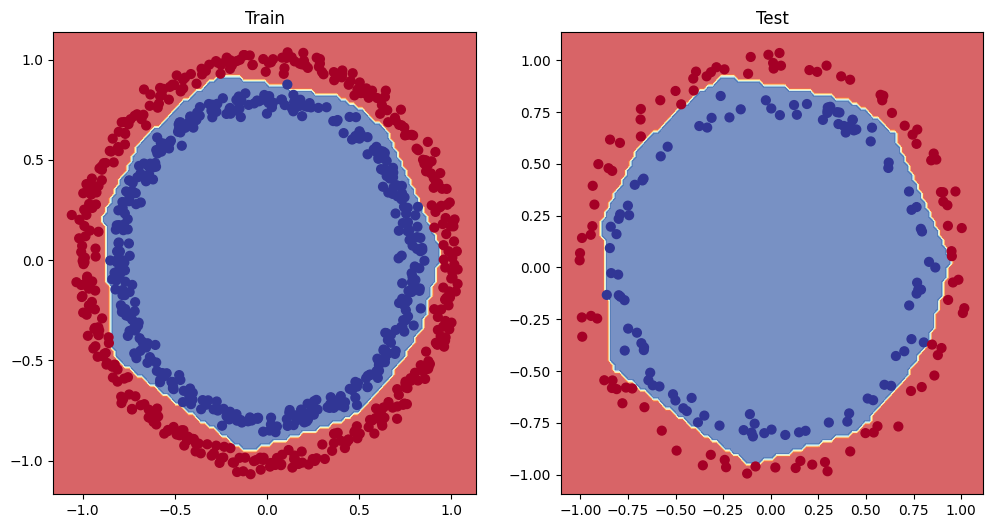

In [71]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model, X=X_test, y=y_test)